In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

pd.set_option("display.max_column", 999)

In [2]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [3]:
tourney_results.shape

(2075, 34)

In [4]:
seeds.shape

(4098, 3)

In [5]:
regular_results.shape

(184024, 34)

In [6]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [7]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [8]:
regular_results.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  \
0      3     14    11    18   14   24    13   23     7     1   22    22    53   
1      8     20    10    19   15   28    16   13     4     4   18    24    67   
2      8     18    17    29   17   26    15   10     5     2   25    22    73   
3      3      9    17    31    6   19    11   12    14     2   18    18    49   
4      6     14    11    13   17   22    12   14     4     4   20    24    62   

   LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0      2     10    16    22   10   22     8   18     9     2   20  
1      6     24     9    20   20   25     7   12     8     6   16  
2      3     26    14    23   31   22     9   12     2     5   23  
3      6     22     8    15   17   20     9   19     4     3   23  
4      6     16    17    27   21   15    12   10     7     1   14

In [9]:
regular_results_swap.head()

Season  DayNum  LTeamID  LScore  WTeamID  WScore WLoc  NumOT  LFGM  LFGA  \
0    2003      10     1328      62     1104      68    N      0    22    53   
1    2003      10     1393      63     1272      70    N      0    24    67   
2    2003      11     1437      61     1266      73    N      0    22    73   
3    2003      11     1457      50     1296      56    N      0    18    49   
4    2003      11     1208      71     1400      77    N      0    24    62   

   LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  WFGM  WFGA  \
0      2     10    16    22   10   22     8   18     9     2   20    27    58   
1      6     24     9    20   20   25     7   12     8     6   16    26    62   
2      3     26    14    23   31   22     9   12     2     5   23    24    58   
3      6     22     8    15   17   20     9   19     4     3   23    18    38   
4      6     16    17    27   21   15    12   10     7     1   14    30    61   

   WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  
0      3     14    11    18   14   24    13   23     7     1   22  
1      8     20    10    19   15   28    16   13     4     4   18  
2      8     18    17    29   17   26    15   10     5     2   25  
3      3      9    17    31    6   19    11   12    14     2   18  
4      6     14    11    13   17   22    12   14     4     4   20

In [10]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [11]:
regular_results.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore location  NumOT  WFGM  \
0    2003      10     1104      68     1328      62        N      0    27   
1    2003      10     1272      70     1393      63        N      0    26   
2    2003      11     1266      73     1437      61        N      0    24   
3    2003      11     1296      56     1457      50        N      0    18   
4    2003      11     1400      77     1208      71        N      0    30   

   WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  \
0    58      3     14    11    18   14   24    13   23     7     1   22    22   
1    62      8     20    10    19   15   28    16   13     4     4   18    24   
2    58      8     18    17    29   17   26    15   10     5     2   25    22   
3    38      3      9    17    31    6   19    11   12    14     2   18    18   
4    61      6     14    11    13   17   22    12   14     4     4   20    24   

   LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0    53      2     10    16    22   10   22     8   18     9     2   20  
1    67      6     24     9    20   20   25     7   12     8     6   16  
2    73      3     26    14    23   31   22     9   12     2     5   23  
3    49      6     22     8    15   17   20     9   19     4     3   23  
4    62      6     16    17    27   21   15    12   10     7     1   14

Swapping here so the model doesnt know

In [12]:
regular_results_swap.head()

Season  DayNum  LTeamID  LScore  WTeamID  WScore location  NumOT  LFGM  \
0    2003      10     1328      62     1104      68        N      0    22   
1    2003      10     1393      63     1272      70        N      0    24   
2    2003      11     1437      61     1266      73        N      0    22   
3    2003      11     1457      50     1296      56        N      0    18   
4    2003      11     1208      71     1400      77        N      0    24   

   LFGA  LFGM3  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  WFGM  \
0    53      2     10    16    22   10   22     8   18     9     2   20    27   
1    67      6     24     9    20   20   25     7   12     8     6   16    26   
2    73      3     26    14    23   31   22     9   12     2     5   23    24   
3    49      6     22     8    15   17   20     9   19     4     3   23    18   
4    62      6     16    17    27   21   15    12   10     7     1   14    30   

   WFGA  WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  
0    58      3     14    11    18   14   24    13   23     7     1   22  
1    62      8     20    10    19   15   28    16   13     4     4   18  
2    58      8     18    17    29   17   26    15   10     5     2   25  
3    38      3      9    17    31    6   19    11   12    14     2   18  
4    61      6     14    11    13   17   22    12   14     4     4   20

In [13]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [14]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

Replacing with T1 and T2 so their is no indication of who is winning 

In [15]:
regular_data.head(10)

Season  DayNum  T1_TeamID  T1_Score  T2_TeamID  T2_Score location  NumOT  \
0    2003      10       1104        68       1328        62        N      0   
1    2003      10       1328        62       1104        68        N      0   
2    2003      10       1393        63       1272        70        N      0   
3    2003      10       1272        70       1393        63        N      0   
4    2003      11       1266        73       1437        61        N      0   
5    2003      11       1437        61       1266        73        N      0   
6    2003      11       1296        56       1457        50        N      0   
7    2003      11       1457        50       1296        56        N      0   
8    2003      11       1400        77       1208        71        N      0   
9    2003      11       1208        71       1400        77        N      0   

   T1_FGM  T1_FGA  T1_FGM3  T1_FGA3  T1_FTM  T1_FTA  T1_OR  T1_DR  T1_Ast  \
0      27      58        3       14      11      18     14     24      13   
1      22      53        2       10      16      22     10     22       8   
2      24      67        6       24       9      20     20     25       7   
3      26      62        8       20      10      19     15     28      16   
4      24      58        8       18      17      29     17     26      15   
5      22      73        3       26      14      23     31     22       9   
6      18      38        3        9      17      31      6     19      11   
7      18      49        6       22       8      15     17     20       9   
8      30      61        6       14      11      13     17     22      12   
9      24      62        6       16      17      27     21     15      12   

   T1_TO  T1_Stl  T1_Blk  T1_PF  T2_FGM  T2_FGA  T2_FGM3  T2_FGA3  T2_FTM  \
0     23       7       1     22      22      53        2       10      16   
1     18       9       2     20      27      58        3       14      11   
2     12       8       6     16      26      62        8       20      10   
3     13       4       4     18      24      67        6       24       9   
4     10       5       2     25      22      73        3       26      14   
5     12       2       5     23      24      58        8       18      17   
6     12      14       2     18      18      49        6       22       8   
7     19       4       3     23      18      38        3        9      17   
8     14       4       4     20      24      62        6       16      17   
9     10       7       1     14      30      61        6       14      11   

   T2_FTA  T2_OR  T2_DR  T2_Ast  T2_TO  T2_Stl  T2_Blk  T2_PF  
0      22     10     22       8     18       9       2     20  
1      18     14     24      13     23       7       1     22  
2      19     15     28      16     13       4       4     18  
3      20     20     25       7     12       8       6     16  
4      23     31     22       9     12       2       5     23  
5      29     17     26      15     10       5       2     25  
6      15     17     20       9     19       4       3     23  
7      31      6     19      11     12      14       2     18  
8      27     21     15      12     10       7       1     14  
9      13     17     22      12     14       4       4     20

In [16]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [17]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [18]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [19]:
regular_data.shape

(368048, 35)

In [20]:
tourney_data.shape

(4150, 35)

In [21]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

Getting Mean from season for below this 

In [22]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [23]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       13.000000  11.428571  5.964286  18.750000  19.285714   
       1103       15.222222  12.629630  7.259259  19.851852  27.777778   
       1104       12.107143  13.285714  6.607143  18.035714  23.250000   
       1105       14.538462  18.653846  9.307692  20.230769  27.000000   
       1106       11.678571  17.035714  8.357143  18.178571  21.714286   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       42.428571  4.750000  12.428571   9.607143   9.142857   
       1103       57.000000  6.666667  18.370370  12.037037  15.481481   
       1104       55.500000  6.357143  19.142857  10.892857  11.678571   
       1105       58.961538  6.269231  17.538462  13.192308  15.807692   
       1106       53.392857  4.785714  15.214286  11.321429  11.785714   

                      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean      mean      mean      mean  
Season T1_TeamID                                           
2003   1102       12.964286  5.428571  1.571429  0.250000  
       1103       15.333333  6.407407  2.851852  0.629630  
       1104       13.857143  5.535714  3.178571  4.285714  
       1105       18.807692  9.384615  4.192308 -4.884615  
       1106       15.071429  8.785714  3.178571 -0.142857

In [24]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

Season T1_TeamID     T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                         mean       mean      mean       mean       mean   
0   2003      1102  19.142857  39.785714  7.821429  20.821429   4.178571   
1   2003      1103  27.148148  55.851852  5.444444  16.074074   9.777778   
2   2003      1104  24.035714  57.178571  6.357143  19.857143  13.571429   
3   2003      1105  24.384615  61.615385  7.576923  20.769231  13.500000   
4   2003      1106  23.428571  55.285714  6.107143  17.642857  12.285714   

      T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM     T2_FGA   T2_FGM3  \
        mean       mean      mean       mean       mean       mean      mean   
0  13.000000  11.428571  5.964286  18.750000  19.285714  42.428571  4.750000   
1  15.222222  12.629630  7.259259  19.851852  27.777778  57.000000  6.666667   
2  12.107143  13.285714  6.607143  18.035714  23.250000  55.500000  6.357143   
3  14.538462  18.653846  9.307692  20.230769  27.000000  58.961538  6.269231   
4  11.678571  17.035714  8.357143  18.178571  21.714286  53.392857  4.785714   

     T2_FGA3      T2_OR     T2_Ast      T2_TO    T2_Stl    T2_Blk PointDiff  
        mean       mean       mean       mean      mean      mean      mean  
0  12.428571   9.607143   9.142857  12.964286  5.428571  1.571429  0.250000  
1  18.370370  12.037037  15.481481  15.333333  6.407407  2.851852  0.629630  
2  19.142857  10.892857  11.678571  13.857143  5.535714  3.178571  4.285714  
3  17.538462  13.192308  15.807692  18.807692  9.384615  4.192308 -4.884615  
4  15.214286  11.321429  11.785714  15.071429  8.785714  3.178571 -0.142857

In [25]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

Season  T1_TeamID  T1_FGMmean  T1_FGAmean  T1_FGM3mean  T1_FGA3mean  \
0    2003       1102   19.142857   39.785714     7.821429    20.821429   
1    2003       1103   27.148148   55.851852     5.444444    16.074074   
2    2003       1104   24.035714   57.178571     6.357143    19.857143   
3    2003       1105   24.384615   61.615385     7.576923    20.769231   
4    2003       1106   23.428571   55.285714     6.107143    17.642857   

   T1_ORmean  T1_Astmean  T1_TOmean  T1_Stlmean  T1_PFmean  T2_FGMmean  \
0   4.178571   13.000000  11.428571    5.964286  18.750000   19.285714   
1   9.777778   15.222222  12.629630    7.259259  19.851852   27.777778   
2  13.571429   12.107143  13.285714    6.607143  18.035714   23.250000   
3  13.500000   14.538462  18.653846    9.307692  20.230769   27.000000   
4  12.285714   11.678571  17.035714    8.357143  18.178571   21.714286   

   T2_FGAmean  T2_FGM3mean  T2_FGA3mean  T2_ORmean  T2_Astmean  T2_TOmean  \
0   42.428571     4.750000    12.428571   9.607143    9.142857  12.964286   
1   57.000000     6.666667    18.370370  12.037037   15.481481  15.333333   
2   55.500000     6.357143    19.142857  10.892857   11.678571  13.857143   
3   58.961538     6.269231    17.538462  13.192308   15.807692  18.807692   
4   53.392857     4.785714    15.214286  11.321429   11.785714  15.071429   

   T2_Stlmean  T2_Blkmean  PointDiffmean  
0    5.428571    1.571429       0.250000  
1    6.407407    2.851852       0.629630  
2    5.535714    3.178571       4.285714  
3    9.384615    4.192308      -4.884615  
4    8.785714    3.178571      -0.142857

## Breaking down into Team 1 and Team 2

In [26]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [27]:
season_statistics_T1.head()

Season  T1_TeamID  T1_FGMmean  T1_FGAmean  T1_FGM3mean  T1_FGA3mean  \
0    2003       1102   19.142857   39.785714     7.821429    20.821429   
1    2003       1103   27.148148   55.851852     5.444444    16.074074   
2    2003       1104   24.035714   57.178571     6.357143    19.857143   
3    2003       1105   24.384615   61.615385     7.576923    20.769231   
4    2003       1106   23.428571   55.285714     6.107143    17.642857   

   T1_ORmean  T1_Astmean  T1_TOmean  T1_Stlmean  T1_PFmean  \
0   4.178571   13.000000  11.428571    5.964286  18.750000   
1   9.777778   15.222222  12.629630    7.259259  19.851852   
2  13.571429   12.107143  13.285714    6.607143  18.035714   
3  13.500000   14.538462  18.653846    9.307692  20.230769   
4  12.285714   11.678571  17.035714    8.357143  18.178571   

   T1_opponent_FGMmean  T1_opponent_FGAmean  T1_opponent_FGM3mean  \
0            19.285714            42.428571              4.750000   
1            27.777778            57.000000              6.666667   
2            23.250000            55.500000              6.357143   
3            27.000000            58.961538              6.269231   
4            21.714286            53.392857              4.785714   

   T1_opponent_FGA3mean  T1_opponent_ORmean  T1_opponent_Astmean  \
0             12.428571            9.607143             9.142857   
1             18.370370           12.037037            15.481481   
2             19.142857           10.892857            11.678571   
3             17.538462           13.192308            15.807692   
4             15.214286           11.321429            11.785714   

   T1_opponent_TOmean  T1_opponent_Stlmean  T1_opponent_Blkmean  \
0           12.964286             5.428571             1.571429   
1           15.333333             6.407407             2.851852   
2           13.857143             5.535714             3.178571   
3           18.807692             9.384615             4.192308   
4           15.071429             8.785714             3.178571   

   T1_PointDiffmean  
0          0.250000  
1          0.629630  
2          4.285714  
3         -4.884615  
4         -0.142857

In [28]:
season_statistics_T2.head()

Season  T2_TeamID  T2_FGMmean  T2_FGAmean  T2_FGM3mean  T2_FGA3mean  \
0    2003       1102   19.142857   39.785714     7.821429    20.821429   
1    2003       1103   27.148148   55.851852     5.444444    16.074074   
2    2003       1104   24.035714   57.178571     6.357143    19.857143   
3    2003       1105   24.384615   61.615385     7.576923    20.769231   
4    2003       1106   23.428571   55.285714     6.107143    17.642857   

   T2_ORmean  T2_Astmean  T2_TOmean  T2_Stlmean  T2_PFmean  \
0   4.178571   13.000000  11.428571    5.964286  18.750000   
1   9.777778   15.222222  12.629630    7.259259  19.851852   
2  13.571429   12.107143  13.285714    6.607143  18.035714   
3  13.500000   14.538462  18.653846    9.307692  20.230769   
4  12.285714   11.678571  17.035714    8.357143  18.178571   

   T2_opponent_FGMmean  T2_opponent_FGAmean  T2_opponent_FGM3mean  \
0            19.285714            42.428571              4.750000   
1            27.777778            57.000000              6.666667   
2            23.250000            55.500000              6.357143   
3            27.000000            58.961538              6.269231   
4            21.714286            53.392857              4.785714   

   T2_opponent_FGA3mean  T2_opponent_ORmean  T2_opponent_Astmean  \
0             12.428571            9.607143             9.142857   
1             18.370370           12.037037            15.481481   
2             19.142857           10.892857            11.678571   
3             17.538462           13.192308            15.807692   
4             15.214286           11.321429            11.785714   

   T2_opponent_TOmean  T2_opponent_Stlmean  T2_opponent_Blkmean  \
0           12.964286             5.428571             1.571429   
1           15.333333             6.407407             2.851852   
2           13.857143             5.535714             3.178571   
3           18.807692             9.384615             4.192308   
4           15.071429             8.785714             3.178571   

   T2_PointDiffmean  
0          0.250000  
1          0.629630  
2          4.285714  
3         -4.884615  
4         -0.142857

In [101]:
season_statistics_T2 = season_statistics_T2[season_statistics_T2['Season'] >= 2015]
season_statistics_T1 = season_statistics_T1[season_statistics_T1['Season'] >= 2015]

In [102]:
mteams_df = pd.read_csv('MTeams.csv')
mteams_df

TeamID          TeamName  FirstD1Season  LastD1Season
0      1101       Abilene Chr           2014          2024
1      1102         Air Force           1985          2024
2      1103             Akron           1985          2024
3      1104           Alabama           1985          2024
4      1105       Alabama A&M           2000          2024
..      ...               ...            ...           ...
373    1474         Queens NC           2023          2024
374    1475  Southern Indiana           2023          2024
375    1476         Stonehill           2023          2024
376    1477   TX A&M Commerce           2023          2024
377    1478          Le Moyne           2024          2024

[378 rows x 4 columns]

In [103]:
merged_df_T2 = pd.merge(season_statistics_T2, mteams_df, left_on='T2_TeamID', right_on='TeamID')

In [104]:
merged_df_T1 = pd.merge(season_statistics_T1, mteams_df, left_on='T1_TeamID', right_on='TeamID')
merged_df_T1

Season  T1_TeamID  T1_FGMmean  T1_FGAmean  T1_FGM3mean  T1_FGA3mean  \
0       2015       1101   21.428571   52.928571     7.250000    19.178571   
1       2016       1101   23.814815   53.925926     6.851852    18.851852   
2       2017       1101   24.440000   53.320000     7.080000    19.080000   
3       2018       1101   25.518519   56.481481     6.481481    19.962963   
4       2019       1101   25.344828   55.241379     7.241379    18.896552   
...      ...        ...         ...         ...          ...          ...   
3535    2023       1476   22.900000   52.433333     7.533333    21.633333   
3536    2024       1476   22.933333   57.933333     8.200000    27.200000   
3537    2023       1477   25.593750   56.687500     8.250000    25.843750   
3538    2024       1477   23.300000   59.400000     8.033333    27.333333   
3539    2024       1478   24.586207   58.517241     9.482759    27.793103   

      T1_ORmean  T1_Astmean  T1_TOmean  T1_Stlmean  T1_PFmean  \
0      8.250000   11.857143  12.821429    5.928571  20.607143   
1      8.185185   12.888889  13.407407    6.740741  22.370370   
2      7.560000   13.600000  14.480000    7.000000  22.160000   
3      9.037037   13.888889  14.407407    7.148148  21.037037   
4      9.068966   14.620690  11.655172    8.000000  19.137931   
...         ...         ...        ...         ...        ...   
3535   4.966667   11.900000  12.800000    6.966667  15.133333   
3536   6.866667   11.866667  12.966667    6.266667  15.466667   
3537   7.500000   13.843750  12.437500    5.562500  18.750000   
3538   7.500000   12.266667  11.000000    7.366667  17.666667   
3539   7.103448   14.931034  10.758621    7.275862  15.655172   

      T1_opponent_FGMmean  T1_opponent_FGAmean  T1_opponent_FGM3mean  \
0               25.035714            50.857143              6.178571   
1               26.481481            53.666667              5.592593   
2               24.840000            53.680000              7.080000   
3               24.777778            54.296296              6.629630   
4               22.482759            51.137931              5.724138   
...                   ...                  ...                   ...   
3535            25.366667            58.833333              8.300000   
3536            26.966667            60.700000             10.066667   
3537            26.093750            55.843750              6.781250   
3538            27.133333            57.600000              6.133333   
3539            25.689655            59.137931              8.482759   

      T1_opponent_FGA3mean  T1_opponent_ORmean  T1_opponent_Astmean  \
0                16.714286           10.035714            12.928571   
1                15.148148            8.592593            12.851852   
2                19.600000           10.640000            13.600000   
3                19.740741            9.925926            12.037037   
4                17.103448            8.827586            11.103448   
...                    ...                 ...                  ...   
3535             24.000000            9.566667            13.900000   
3536             28.033333            9.766667            16.400000   
3537             19.500000            8.125000            13.031250   
3538             17.500000            9.466667            13.833333   
3539             25.413793            9.344828            14.448276   

      T1_opponent_TOmean  T1_opponent_Stlmean  T1_opponent_Blkmean  \
0              13.464286             5.857143             4.250000   
1              13.444444             5.111111             3.296296   
2              14.800000             6.040000             3.160000   
3              15.481481             6.518519             2.925926   
4              15.724138             5.551724             2.965517   
...                  ...                  ...                  ...   
3535           12.900000             6.966667             2.933333   
3536           11.1666

Scrape Try

In [210]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import requests
import time
import requests

In [211]:
# base_urls=[
#           'https://web.archive.org/web/20110311233233/http://www.kenpom.com/',
#           'https://web.archive.org/web/20120311165019/http://kenpom.com/',
#           'https://web.archive.org/web/20130318221134/http://kenpom.com/',
#           'https://web.archive.org/web/20140318100454/http://kenpom.com/',
#           'https://web.archive.org/web/20150316212936/http://kenpom.com/',
#           'https://web.archive.org/web/20160314134726/http://kenpom.com/',
#           'https://web.archive.org/web/20170312131016/http://kenpom.com/',
#           'https://web.archive.org/web/20180311122559/https://kenpom.com/',
#           'https://web.archive.org/web/20190317211809/https://kenpom.com/',
#     'https://web.archive.org/web/20200319000000/https://kenpom.com/index.php?y=2020', # Adjust the timestamp accordingly
#     'https://web.archive.org/web/20210319000000/https://kenpom.com/index.php?y=2021', # Adjust the timestamp accordingly
#     'https://web.archive.org/web/20220319000000/https://kenpom.com/index.php?y=2022', # Adjust the timestamp accordingly
#     'https://web.archive.org/web/20230319000000/https://kenpom.com/index.php?y=2023', # Adjust the timestamp accordingly
#     'https://web.archive.org/web/20240319000000/https://kenpom.com/index.php', #
#          ]

# def scrap_archive(url,year):
#     """
#     Imports raw data from a kenpom archive into a dataframe
#     """
    
#     page = requests.get(url)
#     soup = BeautifulSoup(page.text)
#     table_full = soup.find_all('table', {'id': 'ratings-table'})

#     thead = table_full[0].find_all('thead')
#     table = table_full[0]
    
#     for weird in thead:
#         table = str(table).replace(str(weird), '')

#     df = pd.read_html(table)[0]
#    # if year==2020:
#    #     df['year'] = 2021
#    # else:
#     df['year'] = year
    
#     return df

In [212]:

base_urls=[
          'https://web.archive.org/web/20110311233233/http://www.kenpom.com/',
          'https://web.archive.org/web/20120311165019/http://kenpom.com/',
          'https://web.archive.org/web/20130318221134/http://kenpom.com/',
          'https://web.archive.org/web/20140318100454/http://kenpom.com/',
          'https://web.archive.org/web/20150316212936/http://kenpom.com/',
          'https://web.archive.org/web/20160314134726/http://kenpom.com/',
          'https://web.archive.org/web/20170312131016/http://kenpom.com/',
          'https://web.archive.org/web/20180311122559/https://kenpom.com/',
          'https://web.archive.org/web/20190317211809/https://kenpom.com/',
    'https://web.archive.org/web/20200319000000/https://kenpom.com/index.php?y=2020', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20210319000000/https://kenpom.com/index.php?y=2021', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20220319000000/https://kenpom.com/index.php?y=2022', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20230319000000/https://kenpom.com/index.php?y=2023', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20240319000000/https://kenpom.com/index.php', #
         ]


def scrap_archive(url, year):
    """
    Imports raw data from a kenpom archive into a dataframe
    """
    retries = 3
    delay = 1  # Delay in seconds between retries
    for _ in range(retries):
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
            page = requests.get(url, headers=headers)
            soup = BeautifulSoup(page.text, 'html.parser')
            table_full = soup.find_all('table', {'id': 'ratings-table'})

            thead = table_full[0].find_all('thead')
            table = table_full[0]

            for weird in thead:
                table = str(table).replace(str(weird), '')

            df = pd.read_html(table)[0]
            df['Year'] = year
            return df
        except requests.ConnectionError as e:
            print(f"Connection error occurred: {e}")
            print(f"Retrying in {delay} seconds...")
            time.sleep(delay)
            continue
    else:
        # If all retries fail, raise the last exception
        Exception("Failed to connect after multiple retries")


In [213]:
# def scraping(df,year):
    
#     for url in base_urls:
    
#         print(f'Scrapping: {url}')
#         archive=scrap_archive(url,year)
        
#         df = pd.concat((df, archive), axis=0) 
#         year+=1
    
#     df.columns = ['Rank', 'Team', 'Conference', 'W-L', 'Pyth', 
#              'AdjustO', 'AdjustO Rank', 'AdjustD', 'AdjustD Rank',
#              'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank', 
#              'SOS Pyth', 'SOS Pyth Rank', 'SOS OppO', 'SOS OppO Rank',
#              'SOS OppD', 'SOS OppD Rank', 'NCSOS Pyth', 'NCSOS Pyth Rank', 'Year']
    
#     df=df[[ 'Year', 'Team', 'AdjustO', 'AdjustD', 'Luck','Rank','Pyth']]
#     df.columns=[ 'Season', 'TeamName', 'adj_o', 'adj_d', 'luck','rank','pyth']

#     df.TeamName=df.TeamName.apply(lambda x: re.sub('\d', '', x).strip()).replace('.','')
             
        
#     return df

In [214]:
def scraping(df, year):
    for url in base_urls:
        print(f'Scraping: {url}')
        archive = scrap_archive(url, year)
        df = pd.concat((df, archive), axis=0)
        year += 1
    
    df.columns = ['Rank', 'Team', 'Conference', 'W-L', 'Pyth', 
             'AdjustO', 'AdjustO Rank', 'AdjustD', 'AdjustD Rank',
             'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank', 
             'SOS Pyth', 'SOS Pyth Rank', 'SOS OppO', 'SOS OppO Rank',
             'SOS OppD', 'SOS OppD Rank', 'NCSOS Pyth', 'NCSOS Pyth Rank', 'Year']
    
    df = df[['Year', 'Team', 'AdjustO', 'AdjustD', 'Luck', 'Rank', 'Pyth']]
    df.columns = ['Season', 'TeamName', 'adj_o', 'adj_d', 'luck', 'rank', 'pyth']
    df['TeamName'] = df['TeamName'].apply(lambda x: re.sub('\d', '', x).strip()).replace('.','')
    return df

In [215]:
df=None
year=2011
df=scraping(df,year)
df.head()

Scraping: https://web.archive.org/web/20110311233233/http://www.kenpom.com/
Scraping: https://web.archive.org/web/20120311165019/http://kenpom.com/
Scraping: https://web.archive.org/web/20130318221134/http://kenpom.com/
Scraping: https://web.archive.org/web/20140318100454/http://kenpom.com/
Scraping: https://web.archive.org/web/20150316212936/http://kenpom.com/
Scraping: https://web.archive.org/web/20160314134726/http://kenpom.com/
Scraping: https://web.archive.org/web/20170312131016/http://kenpom.com/
Scraping: https://web.archive.org/web/20180311122559/https://kenpom.com/
Scraping: https://web.archive.org/web/20190317211809/https://kenpom.com/
Scraping: https://web.archive.org/web/20200319000000/https://kenpom.com/index.php?y=2020
Scraping: https://web.archive.org/web/20210319000000/https://kenpom.com/index.php?y=2021
Scraping: https://web.archive.org/web/20220319000000/https://kenpom.com/index.php?y=2022
Scraping: https://web.archive.org/web/20230319000000/https://kenpom.com/index.p

Season  TeamName  adj_o  adj_d   luck  rank    pyth
0    2011  Ohio St.  125.4   88.4  0.043     1  0.9824
1    2011      Duke  118.8   87.2  0.006     2  0.9720
2    2011    Kansas  119.8   88.3  0.071     3  0.9711
3    2011     Texas  114.0   85.3 -0.055     4  0.9657
4    2011    Purdue  116.1   87.2 -0.004     5  0.9641

In [230]:
df_KP = df.copy()
df_KP

Season                TeamName  adj_o  adj_d   luck  rank     pyth
0      2011                Ohio St.  125.4   88.4  0.043     1   0.9824
1      2011                    Duke  118.8   87.2  0.006     2   0.9720
2      2011                  Kansas  119.8   88.3  0.071     3   0.9711
3      2011                   Texas  114.0   85.3 -0.055     4   0.9657
4      2011                  Purdue  116.1   87.2 -0.004     5   0.9641
..      ...                     ...    ...    ...    ...   ...      ...
357    2024                 Pacific   95.3  118.1 -0.014   358 -22.8200
358    2024               Stonehill   91.9  114.7 -0.078   359 -22.8700
359    2024                   IUPUI   92.1  117.7 -0.019   360 -25.6400
360    2024              Coppin St.   85.6  111.5 -0.057   361 -25.9200
361    2024  Mississippi Valley St.   85.3  116.5 -0.060   362 -31.2600

[4938 rows x 7 columns]

In [231]:
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('-',' '))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.lower())
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.strip())
df_KP.TeamName=df_KP.TeamName.replace('mississippi valley st.','mississippi valley state')
#df.TeamName=df.TeamName.replace('texas a&m corpus chris','texas a&m corpus christi')
df_KP.TeamName=df_KP.TeamName.replace('dixie st.','dixie st')
df_KP.TeamName=df_KP.TeamName.replace('st. francis pa','st francis pa')
df_KP.TeamName=df_KP.TeamName.replace('ut rio grande valley','texas rio grande valley')
df_KP.TeamName=df_KP.TeamName.replace('southeast missouri st.','southeast missouri state')
df_KP.TeamName=df_KP.TeamName.replace('tarleton st.','tarleton st')
df_KP.TeamName=df_KP.TeamName.replace('liu','liu brooklyn')
df_KP.TeamName=df_KP.TeamName.replace('cal st. bakersfield','cal state bakersfield')

df_KP.TeamName=df_KP.TeamName.replace('virginia military inst','virginia military	')
df_KP.TeamName=df_KP.TeamName.replace('louisiana saint','louisiana state')
df_KP.TeamName=df_KP.TeamName.replace('nj inst of technology','njit')

df_KP.TeamName=df_KP.TeamName.replace('texas a&m corpus chris','texas a&m corpus')
df_KP.TeamName=df_KP.TeamName.replace('md baltimore county','maryland baltimore county')
#-------------------------------------------------------
# merge with spelling file to get the TeamID
spelling=pd.read_csv('MTeamSpellings.csv',encoding='cp1252')
spelling.columns=['TeamName','TeamID']
spelling.TeamName=spelling.TeamName.apply(lambda x: x.replace('-',' '))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.strip())


df_KP=df_KP.merge(spelling[['TeamName','TeamID']],on='TeamName',how='left')

df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('st.','saint'))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace(';',''))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('\t',''))
df_KP.TeamName=df_KP.TeamName.replace('texas a&m corpus chris','texas a&m corpus')
df_KP.TeamName=df_KP.TeamName.replace('louisiana saint','louisiana state')

df_KP=df_KP.merge(spelling[['TeamName','TeamID']],on='TeamName',how='left')

df_KP.TeamID_x.fillna(df_KP.TeamID_y, inplace=True)

df_KP=df_KP[['Season','TeamID_x','adj_o','adj_d','luck','rank','pyth']]
df_KP.columns=['Season','TeamID','adj_o','adj_d','luck','rank','pyth']
df_KP['TeamID'] = df_KP['TeamID'].astype('Int64')

In [232]:
df_KP.columns=['Season','TeamID','adj_o','adj_d','luck','rank','adj_em']
df_KP

Season  TeamID  adj_o  adj_d   luck  rank   adj_em
0       2011    1326  125.4   88.4  0.043     1   0.9824
1       2011    1181  118.8   87.2  0.006     2   0.9720
2       2011    1242  119.8   88.3  0.071     3   0.9711
3       2011    1400  114.0   85.3 -0.055     4   0.9657
4       2011    1345  116.1   87.2 -0.004     5   0.9641
...      ...     ...    ...    ...    ...   ...      ...
9446    2024    1164   85.6  111.5 -0.057   361 -25.9200
9447    2024    1290   85.3  116.5 -0.060   362 -31.2600
9448    2024    1290   85.3  116.5 -0.060   362 -31.2600
9449    2024    1290   85.3  116.5 -0.060   362 -31.2600
9450    2024    1290   85.3  116.5 -0.060   362 -31.2600

[9451 rows x 7 columns]

In [237]:
season_stats_kp_df_T1 = pd.merge(season_statistics_T1, df_KP, left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_stats_kp_df_T2 = pd.merge(season_statistics_T2, df_KP, left_on=['Season', 'T2_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_stats_kp_df_T2

Season  T2_TeamID  T2_FGMmean  T2_FGAmean  T2_FGM3mean  T2_FGA3mean  \
0       2015       1101   21.428571   52.928571     7.250000    19.178571   
1       2015       1101   21.428571   52.928571     7.250000    19.178571   
2       2015       1101   21.428571   52.928571     7.250000    19.178571   
3       2015       1101   21.428571   52.928571     7.250000    19.178571   
4       2015       1102   23.620690   50.758621     7.172414    20.241379   
...      ...        ...         ...         ...          ...          ...   
9848    2024       1474   26.967742   62.516129     8.419355    25.516129   
9849    2024       1475   22.379310   56.206897     6.448276    20.379310   
9850    2024       1476   22.933333   57.933333     8.200000    27.200000   
9851    2024       1477   23.300000   59.400000     8.033333    27.333333   
9852    2024       1478   24.586207   58.517241     9.482759    27.793103   

      T2_ORmean  T2_Astmean  T2_TOmean  T2_Stlmean  T2_PFmean  \
0      8.250000   11.857143  12.821429    5.928571  20.607143   
1      8.250000   11.857143  12.821429    5.928571  20.607143   
2      8.250000   11.857143  12.821429    5.928571  20.607143   
3      8.250000   11.857143  12.821429    5.928571  20.607143   
4      8.793103   14.896552  11.724138    6.310345  17.827586   
...         ...         ...        ...         ...        ...   
9848   8.645161   12.258065  11.193548    6.645161  17.451613   
9849   8.482759   10.862069  12.827586    6.137931  21.620690   
9850   6.866667   11.866667  12.966667    6.266667  15.466667   
9851   7.500000   12.266667  11.000000    7.366667  17.666667   
9852   7.103448   14.931034  10.758621    7.275862  15.655172   

      T2_opponent_FGMmean  T2_opponent_FGAmean  T2_opponent_FGM3mean  \
0               25.035714            50.857143              6.178571   
1               25.035714            50.857143              6.178571   
2               25.035714            50.857143              6.178571   
3               25.035714            50.857143              6.178571   
4               22.689655            50.482759              8.137931   
...                   ...                  ...                   ...   
9848            30.516129            63.774194              8.000000   
9849            24.034483            55.551724              6.931034   
9850            26.966667            60.700000             10.066667   
9851            27.133333            57.600000              6.133333   
9852            25.689655            59.137931              8.482759   

      T2_opponent_FGA3mean  T2_opponent_ORmean  T2_opponent_Astmean  \
0                16.714286           10.035714            12.928571   
1                16.714286           10.035714            12.928571   
2                16.714286           10.035714            12.928571   
3                16.714286           10.035714            12.928571   
4                22.241379           10.034483            14.448276   
...                    ...                 ...                  ...   
9848             23.419355            9.096774            12.645161   
9849             20.827586            8.448276            12.379310   
9850             28.033333            9.766667            16.400000   
9851             17.500000            9.466667            13.833333   
9852             25.413793            9.344828            14.448276   

      T2_opponent_TOmean  T2_opponent_Stlmean  T2_opponent_Blkmean  \
0              13.464286             5.857143             4.250000   
1              13.464286             5.857143             4.250000   
2              13.464286             5.857143             4.250000   
3              13.464286             5.857143             4.250000   
4              12.379310             5.793103             3.620690   
...                  ...                  ...                  ...   
9848           10.903226             6.516129             4.774194   
9849           11.0689

# About to Merge with Tourney Data

In [238]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

Season  DayNum  T1_TeamID  T1_Score  T2_TeamID  T2_Score
0    2015     134       1214        74       1264        64
1    2015     134       1279        94       1140        90
2    2015     135       1173        56       1129        55
3    2015     135       1352        81       1316        77
4    2015     135       1352        81       1316        77

In [ ]:
tourney_data = pd.merge(tourney_data, season_stats_kp_df_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_stats_kp_df_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = tourney_data.drop(tourney_data.filter(regex='_x|_y').columns, axis=1)
tourney_data = tourney_data[tourney_data['Season'] >= 2015]
tourney_data.columns

In [39]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(19014, 5)

In [40]:
regular_season_effects.head()

Season T1_TeamID T2_TeamID  PointDiff  win
0    2003      1104      1328          6    1
1    2003      1272      1393          7    1
2    2003      1323      1237         44    1
3    2003      1242      1221         24    1
4    2003      1390      1462          1    1

# Get the Seeds so we can put in model

In [43]:
seeds.head()

Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374

In [44]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.tail()

Season Seed  TeamID  seed
4093    2023  Z12    3405    12
4094    2023  Z13    3387    13
4095    2023  Z14    3241    14
4096    2023  Z15    3436    15
4097    2023  Z16    3151    16

In [45]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [46]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

get a seed difference for model 

In [47]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [48]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    4150.000000
mean        0.000000
std        17.332972
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [49]:
tourney_data

Season  DayNum  T1_TeamID  T1_Score  T2_TeamID  T2_Score  T1_FGMmean  \
0       2003     134       1421        92       1411        84   24.379310   
1       2003     136       1112        80       1436        51   30.321429   
2       2003     136       1113        84       1272        71   27.206897   
3       2003     136       1141        79       1166        73   26.620690   
4       2003     136       1143        76       1301        74   27.344828   
...      ...     ...        ...       ...        ...       ...         ...   
4145    2022     147       3301        87       3163        91   29.125000   
4146    2022     147       3276        50       3257        62   26.571429   
4147    2022     151       3390        58       3163        63   27.709677   
4148    2022     151       3257        59       3376        72   28.344828   
4149    2022     153       3163        49       3376        64   29.400000   

      T1_FGAmean  T1_FGM3mean  T1_FGA3mean  T1_ORmean  T1_Astmean  T1_TOmean  \
0      56.793103     6.482759    18.000000  12.275862   13.034483  16.206897   
1      65.714286     7.035714    20.071429  15.178571   17.642857  14.785714   
2      56.896552     4.000000    12.586207  13.689655   15.551724  14.000000   
3      52.689655     6.827586    17.931034  10.586207   15.620690  18.241379   
4      58.724138     6.413793    17.034483  11.241379   16.000000  14.172414   
...          ...          ...          ...        ...         ...        ...   
4145   62.687500     7.406250    20.093750  10.062500   14.250000  12.062500   
4146   58.607143     4.785714    15.000000  11.107143   13.964286  15.392857   
4147   61.677419     7.225806    20.419355  11.580645   15.129032  12.419355   
4148   61.965517     6.137931    16.793103  11.413793   15.862069  14.172414   
4149   60.066667     7.000000    20.500000   8.933333   18.833333  13.566667   

      T1_Stlmean  T1_PFmean  T1_opponent_FGMmean  T1_opponent_FGAmean  \
0       7.068966  19.103448            27.793103            60.965517   
1       8.464286  17.750000            26.357143            64.678571   
2       5.206897  19.413793            24.793103            55.655172   
3       7.103448  20.965517            26.344828            57.931034   
4       6.551724  17.103448            25.379310            58.793103   
...          ...        ...                  ...                  ...   
4145    7.281250  13.187500            21.562500            60.625000   
4146    6.857143  16.142857            22.928571            58.500000   
4147    8.612903  15.967742            20.193548            57.516129   
4148    9.586207  15.896552            19.551724            53.551724   
4149    9.300000  13.566667            20.333333            57.733333   

      T1_opponent_FGM3mean  T1_opponent_FGA3mean  T1_opponent_ORmean  \
0                 7.620690             20.758621           13.724138   
1                 6.321429             19.964286           13.107143   
2                 5.448276             15.896552           11.000000   
3                 4.965517             13.896552           12.241379   
4                 7.103448             21.448276           11.172414   
...                    ...                   ...                 ...   
4145              5.937500             21.000000            8.500000   
4146              6.214286             19.535714            8.178571   
4147              5.548387             16.935484            8.645161   
4148              4.896552             16.793103            8.275862   
4149              5.800000             20.433333            7.633333   

      T1_opponent_Astmean  T1_opponent_TOmean  T1_opponent_Stlmean  \
0               15.862069           12.827586             8.827586   
1               15.464286           16.857143             5.964286   
2               14.068966           15.517241             6.000000   
3               11.793103           16.068966             8.448276   
4               

## See all our features for Model

In [50]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"]

features

['T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_ORmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_ORmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_PointDiffmean',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_ORmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_ORmean',
 'T2_opponent_Astmean',
 'T2_opponent_TOmean',
 'T2_opponent_Stlmean',
 'T2_opponent_Blkmean',
 'T2_PointDiffmean',
 'T1_seed',
 'T2_seed',
 'Seed_diff']

In [51]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [52]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [53]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [54]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )


Fold repeater 0
[18:29:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:29:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:29:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:29:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:29:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mae:13.27024+0.12169	test-mae:13.27661+0.48876
[50]	tr

[50]	train-mae:9.43849+0.04480	test-mae:9.72558+0.24864
[100]	train-mae:9.03850+0.04734	test-mae:9.56056+0.19715
[150]	train-mae:8.79252+0.05078	test-mae:9.52737+0.20515
[200]	train-mae:8.57956+0.05058	test-mae:9.51342+0.20265
[227]	train-mae:8.47768+0.05351	test-mae:9.51541+0.20713
Fold repeater 7
[18:30:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:30:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:30:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:30:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Para

In [55]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([179, 138, 164, 261, 229, 210, 202, 156, 131, 179],
 [9.535479130098619,
  9.542759651218551,
  9.525393313040217,
  9.506152320769896,
  9.52882391271821,
  9.493136334146362,
  9.511871101482805,
  9.512043947340494,
  9.562542131895043,
  9.50776916318629])

In [56]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[18:31:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:31:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:31:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:31:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:31:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 1
[18:31:29] WARNING: /var/folders/nz/j6p8yfhx1mv_

[18:32:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 9
[18:32:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:32:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:32:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:32:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:32:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000

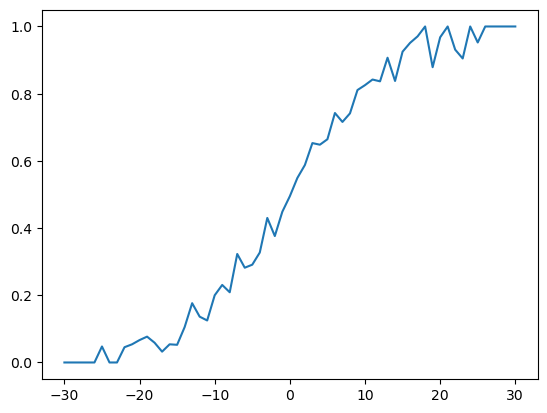

In [57]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [58]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5194392776690502
logloss of cvsplit 1: 0.5193405929820203
logloss of cvsplit 2: 0.5189278002575632
logloss of cvsplit 3: 0.5184994936707522
logloss of cvsplit 4: 0.519324861606671
logloss of cvsplit 5: 0.5189123237728177
logloss of cvsplit 6: 0.5191228431412295
logloss of cvsplit 7: 0.5182052895884451
logloss of cvsplit 8: 0.5186176646724554
logloss of cvsplit 9: 0.5178771692644425


In [59]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.518748938259545
adjusted logloss of cvsplit 1: 0.5179184495273718
adjusted logloss of cvsplit 2: 0.5181322360696738
adjusted logloss of cvsplit 3: 0.5179039228871833
adjusted logloss of cvsplit 4: 0.5182207901092544
adjusted logloss of cvsplit 5: 0.5180207071793098
adjusted logloss of cvsplit 6: 0.5180231762040537
adjusted logloss of cvsplit 7: 0.5170265804241665
adjusted logloss of cvsplit 8: 0.5177234887442348
adjusted logloss of cvsplit 9: 0.5166226540517633


In [60]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.1004515654330875
adjusted logloss of cvsplit 1: 1.0996110714644782
adjusted logloss of cvsplit 2: 1.1005969531646291
adjusted logloss of cvsplit 3: 1.0994118456647757
adjusted logloss of cvsplit 4: 1.099491689233393
adjusted logloss of cvsplit 5: 1.0998190216719066
adjusted logloss of cvsplit 6: 1.099602474903466
adjusted logloss of cvsplit 7: 1.0995338721691295
adjusted logloss of cvsplit 8: 1.0996670192116302
adjusted logloss of cvsplit 9: 1.0985194521215733


In [61]:
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

Season  DayNum  T1_TeamID  T1_Score  T2_TeamID  T2_Score  T1_FGMmean  \
3089    2018     137       1438        54       1420        74   25.000000   
3346    2023     137       1345        58       1192        63   25.441176   
2680    2012     137       1181        70       1250        75   25.757576   
2683    2012     137       1281        84       1313        86   28.000000   
2743    2013     137       1207        68       1195        78   23.000000   
...      ...     ...        ...       ...        ...       ...         ...   
1125    2021     137       1317        78       1345        69   25.080000   
1146    2021     138       1325        62       1438        58   29.545455   
1256    2023     136       1202        68       1438        67   28.000000   
1466    2012     139       3265        76       3208        70   23.156250   
1976    2021     140       3460        66       3116        62   24.040000   

      T1_FGAmean  T1_FGM3mean  T1_FGA3mean  T1_ORmean  T1_Astmean  T1_TOmean  \
3089   54.181818     7.363636    18.878788   8.393939   13.727273   8.575758   
3346   55.382353     6.882353    21.088235  11.029412   15.500000  10.411765   
2680   56.272727     8.121212    21.606061  11.909091   12.454545  12.181818   
2683   55.588235     8.235294    20.823529   9.176471   16.205882  10.294118   
2743   50.419355     5.870968    16.419355   9.225806   14.806452  12.677419   
...          ...          ...          ...        ...         ...        ...   
1125   53.280000     7.400000    19.840000   7.280000   13.040000  12.560000   
1146   60.681818     8.590909    23.500000   8.500000   17.636364  11.545455   
1256   58.774194     9.387097    27.290323   8.935484   16.387097  10.612903   
1466   55.312500     7.031250    21.968750   9.281250   15.343750  13.906250   
1976   59.800000     3.960000    14.960000  15.640000   10.040000  13.960000   

      T1_Stlmean  T1_PFmean  T1_opponent_FGMmean  T1_opponent_FGAmean  \
3089    6.787879  14.060606            18.818182            50.151515   
3346    4.794118  13.705882            24.058824            57.705882   
2680    6.242424  18.181818            25.515152            58.909091   
2683    8.205882  14.117647            24.617647            55.794118   
2743    7.548387  16.870968            19.419355            51.612903   
...          ...        ...                  ...                  ...   
1125    6.840000   5.520000            21.320000            52.920000   
1146    6.636364   4.136364            25.954545            58.454545   
1256    6.354839  17.258065            25.838710            57.645161   
1466    9.687500  12.937500            20.062500            57.937500   
1976    7.840000  16.520000            18.840000            52.840000   

      T1_opponent_FGM3mean  T1_opponent_FGA3mean  T1_opponent_ORmean  \
3089              6.151515             20.303030            8.393939   
3346              6.411765             20.411765            6.323529   
2680              4.454545             14.060606           11.696970   
2683              6.235294             17.205882           10.764706   
2743              5.354839             17.580645           10.806452   
...                    ...                   ...                 ...   
1125              5.720000             18.120000            7.720000   
1146              7.863636             23.363636            8.000000   
1256              6.709677             20.258065            8.258065   
1466              5.718750             17.843750           13.812500   
1976              5.080000             19.200000            7.200000   

      T1_opponent_Astmean  T1_opponent_TOmean  T1_opponent_Stlmean  \
3089             8.848485           12.727273             3.878788   
3346            12.382353            9.088235             6.000000   
2680            11.151515           12.909091             5.666667   
2683            12.823529           14.411765             5.264706   
2743            

In [62]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.49379370115241167
adjusted logloss of cvsplit 1: 0.49324480242930685
adjusted logloss of cvsplit 2: 0.49368071832933585
adjusted logloss of cvsplit 3: 0.4927445574535619
adjusted logloss of cvsplit 4: 0.4932244147503151
adjusted logloss of cvsplit 5: 0.493151575242407
adjusted logloss of cvsplit 6: 0.49311687598179516
adjusted logloss of cvsplit 7: 0.49254783520997625
adjusted logloss of cvsplit 8: 0.4932393640706907
adjusted logloss of cvsplit 9: 0.4922153107145412


In [63]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.49379370115241167
adjusted logloss of cvsplit 1: 0.49324480242930685
adjusted logloss of cvsplit 2: 0.49368071832933585
adjusted logloss of cvsplit 3: 0.4927445574535619
adjusted logloss of cvsplit 4: 0.4932244147503151
adjusted logloss of cvsplit 5: 0.493151575242407
adjusted logloss of cvsplit 6: 0.49311687598179516
adjusted logloss of cvsplit 7: 0.49254783520997625
adjusted logloss of cvsplit 8: 0.4932393640706907
adjusted logloss of cvsplit 9: 0.4922153107145412


season
2003    0.522089
2004    0.483055
2005    0.485678
2006    0.552691
2007    0.421830
2008    0.455990
2009    0.462552
2010    0.469686
2011    0.481561
2012    0.488330
2013    0.507786
2014    0.492135
2015    0.424935
2016    0.537836
2017    0.477070
2018    0.530710
2019    0.428936
2021    0.530322
2022    0.537236
2023    0.575304
dtype: float64

# Do Submission formatting Below This 

In [80]:
sub = pd.read_csv("SampleSubmission2023.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()

ID  Pred  Season  T1_TeamID  T2_TeamID
0  2023_1101_1102   0.5    2023       1101       1102
1  2023_1101_1103   0.5    2023       1101       1103
2  2023_1101_1104   0.5    2023       1101       1104
3  2023_1101_1105   0.5    2023       1101       1105
4  2023_1101_1106   0.5    2023       1101       1106

In [81]:
seeds_T1.tail()

Season  T1_TeamID  T1_seed
4093    2023       3405       12
4094    2023       3387       13
4095    2023       3241       14
4096    2023       3436       15
4097    2023       3151       16

In [82]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')


sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')


sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

ID  Pred  Season  T1_TeamID  T2_TeamID  T1_FGMmean  T1_FGAmean  \
0  2023_1101_1102   0.5    2023       1101       1102   25.384615   58.346154   
1  2023_1101_1103   0.5    2023       1101       1103   25.384615   58.346154   
2  2023_1101_1104   0.5    2023       1101       1104   25.384615   58.346154   
3  2023_1101_1105   0.5    2023       1101       1105   25.384615   58.346154   
4  2023_1101_1106   0.5    2023       1101       1106   25.384615   58.346154   

   T1_FGM3mean  T1_FGA3mean  T1_ORmean  T1_Astmean  T1_TOmean  T1_Stlmean  \
0     6.692308         19.5   7.615385   14.769231  11.846154    7.961538   
1     6.692308         19.5   7.615385   14.769231  11.846154    7.961538   
2     6.692308         19.5   7.615385   14.769231  11.846154    7.961538   
3     6.692308         19.5   7.615385   14.769231  11.846154    7.961538   
4     6.692308         19.5   7.615385   14.769231  11.846154    7.961538   

   T1_PFmean  T1_opponent_FGMmean  T1_opponent_FGAmean  T1_opponent_FGM3mean  \
0  20.884615            25.807692            51.423077              6.576923   
1  20.884615            25.807692            51.423077              6.576923   
2  20.884615            25.807692            51.423077              6.576923   
3  20.884615            25.807692            51.423077              6.576923   
4  20.884615            25.807692            51.423077              6.576923   

   T1_opponent_FGA3mean  T1_opponent_ORmean  T1_opponent_Astmean  \
0             17.269231            7.346154            13.538462   
1             17.269231            7.346154            13.538462   
2             17.269231            7.346154            13.538462   
3             17.269231            7.346154            13.538462   
4             17.269231            7.346154            13.538462   

   T1_opponent_TOmean  T1_opponent_Stlmean  T1_opponent_Blkmean  \
0           15.769231             5.384615             3.192308   
1           15.769231             5.384615             3.192308   
2           15.769231             5.384615             3.192308   
3           15.769231             5.384615             3.192308   
4           15.769231             5.384615             3.192308   

   T1_PointDiffmean  T2_FGMmean  T2_FGAmean  T2_FGM3mean  T2_FGA3mean  \
0         -3.692308   23.625000   51.125000     8.156250    22.906250   
1         -3.692308   25.387097   57.451613     8.806452    25.193548   
2         -3.692308   27.764706   62.205882    10.058824    29.764706   
3         -3.692308   24.233333   56.500000     6.400000    18.466667   
4         -3.692308   21.800000   58.566667     5.966667    19.400000   

   T2_ORmean  T2_Astmean  T2_TOmean  T2_Stlmean  T2_PFmean  \
0   5.625000   15.312500  10.906250    5.750000  17.000000   
1   8.387097   13.000000  10.838710    5.774194  16.193548   
2  11.264706   15.205882  13.588235    6.058824  18.617647   
3   8.766667   12.066667  13.733333    7.500000  19.100000   
4  10.300000    9.733333  12.300000    5.666667  17.866667   

   T2_opponent_FGMmean  T2_opponent_FGAmean  T2_opponent_FGM3mean  \
0            23.875000            53.687500              5.187500   
1            24.709677            56.806452              7.064516   
2            23.941176            64.382353              5.529412   
3            23.600000            55.300000              7.466667   
4            25.733333            58.800000              6.966667   

   T2_opponent_FGA3mean  T2_opponent_ORmean  T2_opponent_Astmean  \
0             17.687500            7.937500            10.093750   
1             20.096774            7.322581            11.483871   
2             19.705882            9.500000            10.000000   
3             22.066667            9.966667            12.600000   
4             20.400000           10.633333            11.833333   

   T2_opponent_TOmean  T2_opponent_Stlmean  T2_opponent_Blkmean  \
0           10.687500             5.718750             3.093750   
1 

In [83]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [84]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
[18:47:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 1
[18:47:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 2
[18:47:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 3
[18:47:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 4
[18:47:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [85]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [86]:
sub.head()

ID      Pred  Season  T1_TeamID  T2_TeamID  T1_FGMmean  \
0  2023_1101_1102  0.815114    2023       1101       1102   25.384615   
1  2023_1101_1103  0.756845    2023       1101       1103   25.384615   
2  2023_1101_1104  0.787447    2023       1101       1104   25.384615   
3  2023_1101_1105  0.854692    2023       1101       1105   25.384615   
4  2023_1101_1106  0.881146    2023       1101       1106   25.384615   

   T1_FGAmean  T1_FGM3mean  T1_FGA3mean  T1_ORmean  T1_Astmean  T1_TOmean  \
0   58.346154     6.692308         19.5   7.615385   14.769231  11.846154   
1   58.346154     6.692308         19.5   7.615385   14.769231  11.846154   
2   58.346154     6.692308         19.5   7.615385   14.769231  11.846154   
3   58.346154     6.692308         19.5   7.615385   14.769231  11.846154   
4   58.346154     6.692308         19.5   7.615385   14.769231  11.846154   

   T1_Stlmean  T1_PFmean  T1_opponent_FGMmean  T1_opponent_FGAmean  \
0    7.961538  20.884615            25.807692            51.423077   
1    7.961538  20.884615            25.807692            51.423077   
2    7.961538  20.884615            25.807692            51.423077   
3    7.961538  20.884615            25.807692            51.423077   
4    7.961538  20.884615            25.807692            51.423077   

   T1_opponent_FGM3mean  T1_opponent_FGA3mean  T1_opponent_ORmean  \
0              6.576923             17.269231            7.346154   
1              6.576923             17.269231            7.346154   
2              6.576923             17.269231            7.346154   
3              6.576923             17.269231            7.346154   
4              6.576923             17.269231            7.346154   

   T1_opponent_Astmean  T1_opponent_TOmean  T1_opponent_Stlmean  \
0            13.538462           15.769231             5.384615   
1            13.538462           15.769231             5.384615   
2            13.538462           15.769231             5.384615   
3            13.538462           15.769231             5.384615   
4            13.538462           15.769231             5.384615   

   T1_opponent_Blkmean  T1_PointDiffmean  T2_FGMmean  T2_FGAmean  T2_FGM3mean  \
0             3.192308         -3.692308   23.625000   51.125000     8.156250   
1             3.192308         -3.692308   25.387097   57.451613     8.806452   
2             3.192308         -3.692308   27.764706   62.205882    10.058824   
3             3.192308         -3.692308   24.233333   56.500000     6.400000   
4             3.192308         -3.692308   21.800000   58.566667     5.966667   

   T2_FGA3mean  T2_ORmean  T2_Astmean  T2_TOmean  T2_Stlmean  T2_PFmean  \
0    22.906250   5.625000   15.312500  10.906250    5.750000  17.000000   
1    25.193548   8.387097   13.000000  10.838710    5.774194  16.193548   
2    29.764706  11.264706   15.205882  13.588235    6.058824  18.617647   
3    18.466667   8.766667   12.066667  13.733333    7.500000  19.100000   
4    19.400000  10.300000    9.733333  12.300000    5.666667  17.866667   

   T2_opponent_FGMmean  T2_opponent_FGAmean  T2_opponent_FGM3mean  \
0            23.875000            53.687500              5.187500   
1            24.709677            56.806452              7.064516   
2            23.941176            64.382353              5.529412   
3            23.600000            55.300000              7.466667   
4            25.733333            58.800000              6.966667   

   T2_opponent_FGA3mean  T2_opponent_ORmean  T2_opponent_Astmean  \
0             17.687500            7.937500            10.093750   
1             20.096774            7.322581            11.483871   
2             19.705882            9.500000            10.000000   
3             22.066667            9.966667            12.600000   
4             20.400000           10.633333            11.833333   

   T2_opponent_TOmean  T2_opponent_Stlmean  T2_opponent_Blkmean  \
0           10.687500             5.718750   

In [90]:
round_slots = pd.read_csv('MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2023]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds = pd.read_csv('2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M']
seeds_w = seeds[seeds['Tournament'] == 'W']

# Predictions of last year's 1st place solution by RustyB: https://www.kaggle.com/code/rustyb/paris-madness-2023/output
preds = pd.read_csv('submission.csv') 
preds['ID'] = preds['ID'].str.split('_')

In [97]:
from tqdm import tqdm
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        team1, team2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team1)][str(team2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = [team1, team2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []
    
    # Precompute random-values
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, random_values[b-1], sim)
        
        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

n_brackets = 1000
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=True)
result_w['Tournament'] = 'W'
submission = pd.concat([result_m, result_w])
submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 28744.06it/s]


In [98]:
# submission.to_csv('submission.csv')
submission = submission[['Tournament', 'Bracket', 'Slot', 'Team']]
submission

Tournament  Bracket  Slot Team
RowId                                
0               M        1  R1W1  W01
1               M        1  R1W2  W15
2               M        1  R1W3  W14
3               M        1  R1W4  W13
4               M        1  R1W5  W05
...           ...      ...   ...  ...
125995          W     1000  R4Y1  Y01
125996          W     1000  R4Z1  Z11
125997          W     1000  R5WX  X16
125998          W     1000  R5YZ  Z11
125999          W     1000  R6CH  X16

[126000 rows x 4 columns]